In [1]:
import pandas as pd
import geopandas as gp
import os

'''
Sources:
shp: https://www.nconemap.gov/datasets/voting-precincts/explore?location=35.097107%2C-79.888900%2C7.41
'''

'\nSources:\nshp: https://www.nconemap.gov/datasets/voting-precincts/explore?location=35.097107%2C-79.888900%2C7.41\n'

In [2]:
gdf = gp.read_file("./raw-from-source/Voting_Precincts/Voting_Precincts.shp")
df = pd.read_table("./raw-from-source/results_pct_20221108 (1).zip", sep = "\t")

In [3]:
len(set(gdf.prec_id) - set(df['Precinct']))

12

In [4]:
len(set(df['Precinct'])-set(gdf.prec_id))

205

In [5]:
gdf.prec_id.nunique()

1932

In [6]:
df.Precinct.nunique()

2125

# Process election results

From Ballotpedia:
- To include: US Senate, US House, State Senate, State House, State Supreme Court 
    - 'US SENATE'
    - 'US HOUSE OF REPRESENTATIVES DISTRICT XX'
    - 'NC STATE SENATE DISTRICT XX'
    - 'NC HOUSE OF REPRESENTATIVES DISTRICT XXX'
    - 'NC SUPREME COURT ASSOCIATE JUSTICE SEAT XX'
    
- Not sure: Intermediate Appelate Courts
    - 'NC COURT OF APPEALS JUDGE SEAT XX'
- Not to include: School boards, Municipal government, local ballot measures

## Grab info for column dictionaries

In [11]:
#Set party col
potential_party = df['Choice Party']
party_dict = {'DEM':'D','LIB':'L','REP':'R','UNA':'U','GRE':'G', "na":"N"}
df["col_party"] = df.loc[df['Choice Party'].isin(party_dict.keys()), "Choice Party"].map(party_dict)
df.loc[df["col_party"].isna(), 'col_party'] = "N"


#Set last name abrv - will need to edit 
df["col_last_name"] = "na"
df.loc[df["Choice"].str.contains(". "), "col_last_name"] = df["Choice"].str.split(pat=" ").str[2].str.slice(stop=3).str.upper()
df.loc[df["col_last_name"].isna(), "col_last_name"] = df["Choice"].str.split(pat=" ").str[1].str.slice(stop=3).str.upper()
df.loc[df["Choice"] == "Write-In (Miscellaneous)", "col_last_name"] = "OWR"


#Set contest
general_office_dict = {"US SENATE":"USS", "US HOUSE": "CON", "STATE SENATE":"SU", "NC HOUSE OF REPRESENTATIVES": "SL", 
                       "NC SUPREME COURT": "SSC", "NC COURT OF APPEALS JUDGE":"IA"}
df["col_office"]='na'
df.loc[(df["Contest Name"].str.contains("US SENATE")), "col_office"] = "US SENATE"
df.loc[(df["Contest Name"].str.contains("US HOUSE")), "col_office"] = "US HOUSE"
df.loc[(df["Contest Name"].str.contains("STATE SENATE")), "col_office"] = "STATE SENATE"
df.loc[(df["Contest Name"].str.contains("NC HOUSE OF REPRESENTATIVES")), "col_office"] = "NC HOUSE OF REPRESENTATIVES"
df.loc[(df["Contest Name"].str.contains("NC SUPREME COURT")), "col_office"] = "NC SUPREME COURT"
df.loc[(df["Contest Name"].str.contains("NC COURT OF APPEALS JUDGE")), "col_office"] = "NC COURT OF APPEALS JUDGE"
df["office_abr"] = df["col_office"].map(general_office_dict)


#Set districts

#Get CONG DIST
df["col_cong_dist"] = "na"
df.loc[df["Contest Name"].str.contains("US HOUSE"), "col_cong_dist"] = df["Contest Name"].str.split(pat=" ").str[-1]
#GET state sen dist
df["col_su_dist"] = "na"
df.loc[df["Contest Name"].str.contains("STATE SENATE"), "col_su_dist"] = df["Contest Name"].str.split(pat=" ").str[-1]
#GET state house dist
df["col_sl_dist"] = "na"
df.loc[df["Contest Name"].str.contains("NC HOUSE OF REPRESENTATIVES"), "col_sl_dist"] = df["Contest Name"].str.split(pat=" ").str[-1]
#GET ssc seat
df["col_ssc_seat"] = "na"
df.loc[df["Contest Name"].str.contains("NC SUPREME COURT"), "col_ssc_seat"] = df["Contest Name"].str.split(pat=" ").str[-1]
#GET court of appeals dist
df["col_ia_seat"] = "na"
df.loc[df["Contest Name"].str.contains("NC COURT OF APPEALS JUDGE"), "col_ia_seat"] = df["Contest Name"].str.split(pat=" ").str[-1]


#Create column names
df["full_col_names"] = "na"
#cong
df.loc[df["Contest Name"].str.contains("US HOUSE"), "full_col_names"] = "G" + df["office_abr"] + df['col_cong_dist'] + df['col_party'] + df['col_last_name']
#us sen
df.loc[df["Contest Name"].str.contains("US SENATE"), "full_col_names"] = "G22" + df["office_abr"] + df['col_party'] + df['col_last_name']
#state sen
df.loc[df["Contest Name"].str.contains("STATE SENATE"), "full_col_names"] = "G" + df["office_abr"] + df['col_su_dist'].str.zfill(2) + df['col_party'] + df['col_last_name']
#state house
df.loc[df["Contest Name"].str.contains("NC HOUSE OF REPRESENTATIVES"), "full_col_names"] = "G" + df["office_abr"] + df['col_sl_dist'].str.zfill(3) + df['col_party'] + df['col_last_name']
#state ssc
df.loc[df["Contest Name"].str.contains("NC SUPREME COURT"), "full_col_names"] = "G22" + df["office_abr"] + df["col_ssc_seat"].str.zfill(2) + df['col_last_name']
#IA court
df.loc[df["Contest Name"].str.contains("NC COURT OF APPEALS JUDGE"), "full_col_names"] = "G22" + df["office_abr"] + df["col_ia_seat"].str.zfill(2) + df['col_last_name']

#filter
df = df[~df["office_abr"].isna()]

In [12]:
df[(df["Precinct"].str.lower().str.contains("absentee"))|(df["Precinct"].str.lower().str.contains("one stop"))]

,County,Election Date,Precinct,Contest Group ID,Contest Type,Contest Name,Choice,Choice Party,Vote For,Election Day,...,col_party,col_last_name,col_office,office_abr,col_cong_dist,col_su_dist,col_sl_dist,col_ssc_seat,col_ia_seat,full_col_names
486,HENDERSON,11/08/2022,ONE STOP 1,1041,S,NC COURT OF APPEALS JUDGE SEAT 10,Gale Murray Adams,DEM,1,0,...,D,ADA,NC COURT OF APPEALS JUDGE,IA,na,na,na,na,10,G22IA10ADA
487,HENDERSON,11/08/2022,ONE STOP 1,1329,S,NC STATE SENATE DISTRICT 48,Jay Carey,DEM,1,0,...,D,CAR,STATE SENATE,SU,na,48,na,na,na,GSU48DCAR
490,HENDERSON,11/08/2022,ONE STOP 2,1039,S,NC COURT OF APPEALS JUDGE SEAT 08,Julee Tate Flood,REP,1,0,...,R,FLO,NC COURT OF APPEALS JUDGE,IA,na,na,na,na,08,G22IA08FLO
494,HENDERSON,11/08/2022,ONE STOP 4,1041,S,NC COURT OF APPEALS JUDGE SEAT 10,Gale Murray Adams,DEM,1,0,...,D,ADA,NC COURT OF APPEALS JUDGE,IA,na,na,na,na,10,G22IA10ADA
495,HENDERSON,11/08/2022,ONE STOP 4,1329,S,NC STATE SENATE DISTRICT 48,Jay Carey,DEM,1,0,...,D,CAR,STATE SENATE,SU,na,48,na,na,na,GSU48DCAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171495,YADKIN,11/08/2022,ONE STOP,1378,S,US SENATE,Shannon W. Bray,LIB,1,0,...,L,BRA,US SENATE,USS,na,na,na,na,na,G22USSLBRA
171670,WILKES,11/08/2022,ABSENTEE,1041,S,NC COURT OF APPEALS JUDGE SEAT 10,Gale Murray Adams,DEM,1,0,...,D,ADA,NC COURT OF APPEALS JUDGE,IA,na,na,na,na,10,G22IA10ADA
171671,WILKES,11/08/2022,ABSENTEE,1041,S,NC COURT OF APPEALS JUDGE SEAT 10,John M. Tyson,REP,1,0,...,R,TYS,NC COURT OF APPEALS JUDGE,IA,na,na,na,na,10,G22IA10TYS
171672,WILKES,11/08/2022,ABSENTEE,1317,S,NC STATE SENATE DISTRICT 36,Eddie Settle,REP,1,0,...,R,SET,STATE SENATE,SU,na,36,na,na,na,GSU36RSET


In [14]:
df[df["Choice Party"].isna()]

,County,Election Date,Precinct,Contest Group ID,Contest Type,Contest Name,Choice,Choice Party,Vote For,Election Day,...,col_party,col_last_name,col_office,office_abr,col_cong_dist,col_su_dist,col_sl_dist,col_ssc_seat,col_ia_seat,full_col_names
6,COLUMBUS,11/08/2022,P19,1378,S,US SENATE,Write-In (Miscellaneous),NaN,1,0,...,N,OWR,US SENATE,USS,na,na,na,na,na,G22USSNOWR
16,CLEVELAND,11/08/2022,CASAR,1378,S,US SENATE,Write-In (Miscellaneous),NaN,1,1,...,N,OWR,US SENATE,USS,na,na,na,na,na,G22USSNOWR
22,CLEVELAND,11/08/2022,GROVER,1373,S,US HOUSE OF REPRESENTATIVES DISTRICT 10,Write-In (Miscellaneous),NaN,1,0,...,N,OWR,US HOUSE,CON,10,na,na,na,na,GCON10NOWR
132,CARTERET,11/08/2022,MCRK,1378,S,US SENATE,Write-In (Miscellaneous),NaN,1,0,...,N,OWR,US SENATE,USS,na,na,na,na,na,G22USSNOWR
133,CARTERET,11/08/2022,MERR,1378,S,US SENATE,Write-In (Miscellaneous),NaN,1,0,...,N,OWR,US SENATE,USS,na,na,na,na,na,G22USSNOWR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171689,WILKES,11/08/2022,PROVISIONAL,1378,S,US SENATE,Write-In (Miscellaneous),NaN,1,0,...,N,OWR,US SENATE,USS,na,na,na,na,na,G22USSNOWR
171771,ROWAN,11/08/2022,12,1378,S,US SENATE,Write-In (Miscellaneous),NaN,1,0,...,N,OWR,US SENATE,USS,na,na,na,na,na,G22USSNOWR
171807,YANCEY,11/08/2022,08 CRA,1378,S,US SENATE,Write-In (Miscellaneous),NaN,1,1,...,N,OWR,US SENATE,USS,na,na,na,na,na,G22USSNOWR
171814,YANCEY,11/08/2022,10 PEN,1378,S,US SENATE,Write-In (Miscellaneous),NaN,1,0,...,N,OWR,US SENATE,USS,na,na,na,na,na,G22USSNOWR


## Pivot

In [15]:
df.columns

Index(['County', 'Election Date', 'Precinct', 'Contest Group ID',
       'Contest Type', 'Contest Name', 'Choice', 'Choice Party', 'Vote For',
       'Election Day', 'One Stop', 'Absentee by Mail', 'Provisional',
       'Total Votes', 'Real Precinct', 'Unnamed: 15', 'col_party',
       'col_last_name', 'col_office', 'office_abr', 'col_cong_dist',
       'col_su_dist', 'col_sl_dist', 'col_ssc_seat', 'col_ia_seat',
       'full_col_names'],
      dtype='object')

In [16]:
## PIVOT RESULTS
df_pivot = df.pivot_table(index = ['County','Precinct'],
                         columns = ['full_col_names'],
                        values = ['Total Votes'],
                         aggfunc = 'sum')

#Clean up the indices
df_pivot.reset_index(inplace = True,drop=False)

In [17]:
df_pivot

County Precinct Total Votes                        \
full_col_names                     G22IA08FLO G22IA08THO G22IA09SAL   
0               ALAMANCE       01      1733.0      397.0      377.0   
1               ALAMANCE       02      1918.0      401.0      392.0   
2               ALAMANCE      035      1230.0      855.0      829.0   
3               ALAMANCE      03C       961.0      665.0      622.0   
4               ALAMANCE      03N       922.0      742.0      716.0   
...                  ...      ...         ...        ...        ...   
2972              YANCEY   07 BRU       181.0       87.0       81.0   
2973              YANCEY   08 CRA      1084.0      454.0      449.0   
2974              YANCEY   09 SOU       718.0      613.0      584.0   
2975              YANCEY   10 PEN       250.0      100.0       98.0   
2976              YANCEY   11 PRI       576.0      185.0      184.0   

                                                                       ...  \
full_col_names G22IA09STR G22IA10ADA G22IA10TYS G22IA11JAC G22IA11STA  ...   
0                  1757.0      396.0     1738.0      395.0     1735.0  ...   
1                  1925.0      404.0     1916.0      395.0     1923.0  ...   
2                  1256.0      861.0     1222.0      857.0     1227.0  ...   
3                  1004.0      657.0      964.0      646.0      975.0  ...   
4                   955.0      729.0      935.0      738.0      922.0  ...   
...                   ...        ...        ...        ...        ...  ...   
2972                186.0       83.0      185.0       83.0      185.0  ...   
2973               1092.0      447.0     1089.0      454.0     1084.0  ...   
2974                746.0      601.0      727.0      611.0      719.0  ...   
2975                253.0       99.0      250.0       97.0      254.0  ...   
2976                583.0      183.0      581.0      185.0      574.0  ...   

                                                                            \
full_col_names GSU45RPRO GSU46DMAR GSU46RDAN GSU47RHIS GSU48DCAR GSU48RMOF   
0                    NaN       NaN       NaN       NaN       NaN       NaN   
1                    NaN       NaN       NaN       NaN       NaN       NaN   
2                    NaN       NaN       NaN       NaN       NaN       NaN   
3                    NaN       NaN       NaN       NaN       NaN       NaN   
4                    NaN       NaN       NaN       NaN       NaN       NaN   
...                  ...       ...       ...       ...       ...       ...   
2972                 NaN       NaN       NaN     188.0       NaN       NaN   
2973                 NaN       NaN       NaN    1178.0       NaN       NaN   
2974                 NaN       NaN       NaN     796.0       NaN       NaN   
2975                 NaN       NaN       NaN     269.0       NaN       NaN   
2976                 NaN       NaN       NaN     618.0       NaN       NaN   

                                                        
full_col_names GSU49DMAY GSU49RAND GSU50DMCC GSU50RCOR  
0                    NaN       NaN       NaN       NaN  
1                    NaN       NaN       NaN       NaN  
2                    NaN       NaN       NaN       NaN  
3                    NaN       NaN       NaN       NaN  
4                    NaN       NaN       NaN       NaN  
...                  ...       ...       ...       ...  
2972                 NaN       NaN       NaN       NaN  
2973                 NaN       NaN       NaN       NaN  
2974                 NaN       NaN       NaN       NaN  
2975                 NaN       NaN       NaN       NaN  
2976                 NaN       NaN       NaN       NaN  

[2977 rows x 363 columns]

In [20]:
(df.Precinct + df.County).nunique()

2977

In [18]:
df.Precinct.nunique()

2125

In [22]:
(gdf.prec_id+gdf.county_nam).nunique()

2663

In [23]:
gdf

,objectid,id,prec_id,enr_desc,county_nam,of_prec_id,county_id,blockid,st_areasha,st_perimet,geometry
0,1,1,0003,ALBEMARLE NUMBER 3,STANLY,None,84,None,4.323128e+07,40731.350779,"POLYGON ((501353.677 178235.458, 501326.512 17..."
1,2,2,0003,DREXEL 03,BURKE,None,12,None,1.083199e+08,49918.849040,"POLYGON ((372074.708 221553.271, 372077.123 22..."
2,3,22,0019,LINVILLE 01,BURKE,None,12,None,8.718055e+08,160866.952809,"POLYGON ((348092.062 224114.752, 348049.712 22..."
3,4,23,0019,RIDENHOUR,STANLY,None,84,None,8.992723e+08,125698.778851,"POLYGON ((484800.946 182206.711, 484812.120 18..."
4,5,71,007,007,MECKLENBURG,None,60,None,1.852384e+07,17915.436972,"POLYGON ((446820.325 159981.344, 446765.383 16..."
...,...,...,...,...,...,...,...,...,...,...,...
2658,2659,10136,GLD118,GOLDSTON,CHATHAM,None,19,None,2.578724e+09,286678.498949,"POLYGON ((586640.476 199186.510, 586637.836 19..."
2659,2660,10137,MON119,MONCURE,CHATHAM,None,19,None,2.317259e+09,309357.300937,"POLYGON ((591910.971 203450.739, 591911.489 20..."
2660,2661,10138,WM,WEST MOYOCK,CURRITUCK,None,27,None,1.134493e+09,160500.010788,"POLYGON ((862732.647 302036.702, 862720.292 30..."
2661,2662,10139,CO,COINJOCK,CURRITUCK,None,27,None,9.606002e+08,159781.759396,"POLYGON ((874730.995 293329.153, 874731.009 29..."


## Re-allocating absentee votes
Fo now just cut out/ create separate dataframe for votes not assigned to a specific precint (absentee, one stop)
for write in, assign last name = OWR

In [104]:
df['Precinct'][df['Precinct'].str.lower().str.contains("one stop")].unique()

array(['ONE STOP 1', 'ONE STOP 2', 'ONE STOP 3', 'ONE STOP 4', 'ONE STOP',
       'ONE STOP CB', 'ONE STOP CFCC', 'ONE STOP CFN', 'ONE STOP NLB',
       'ONE STOP SRC', 'ONE STOP BOE', 'ONE STOP ROCKFISH',
       'ONE STOP HOS', 'ONE STOP DANBURY', 'ONE STOP KING',
       'ONE STOP WALNUT COVE', 'ONE STOP RESOURCE CENTER',
       'ONE STOP SHUFORD REC'], dtype=object)

In [105]:
df['Precinct'][df['Precinct'].str.lower().str.contains("absentee")].unique()

array(['ABSENTEE', 'SUPP ABSENTEE', 'SUPPLEMENTAL ABSENTEE',
       'ABSENTEE MAIL', 'ABSENTEE SUPPLEMENTAL', 'ABSENTEE BY MAIL',
       'SUPPLEMNTAL ABSENTEE', 'ABSENTEE 1'], dtype=object)

In [114]:
df['Precinct'][(~df['Precinct'].str.lower().str.contains("one stop"))&(~df['Precinct'].str.lower().str.contains("absentee"))].nunique()

2099

In [112]:
gdf['prec_id'].nunique()

1932

# GDF

<AxesSubplot:>

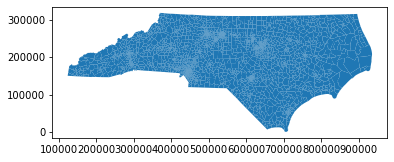

In [73]:
gdf.plot()

In [75]:
gdf['geometry'].isna().any()

False

In [76]:
gdf

,objectid,id,prec_id,enr_desc,county_nam,of_prec_id,county_id,blockid,st_areasha,st_perimet,geometry
0,1,1,0003,ALBEMARLE NUMBER 3,STANLY,None,84,None,4.323128e+07,40731.350779,"POLYGON ((501353.677 178235.458, 501326.512 17..."
1,2,2,0003,DREXEL 03,BURKE,None,12,None,1.083199e+08,49918.849040,"POLYGON ((372074.708 221553.271, 372077.123 22..."
2,3,22,0019,LINVILLE 01,BURKE,None,12,None,8.718055e+08,160866.952809,"POLYGON ((348092.062 224114.752, 348049.712 22..."
3,4,23,0019,RIDENHOUR,STANLY,None,84,None,8.992723e+08,125698.778851,"POLYGON ((484800.946 182206.711, 484812.120 18..."
4,5,71,007,007,MECKLENBURG,None,60,None,1.852384e+07,17915.436972,"POLYGON ((446820.325 159981.344, 446765.383 16..."
...,...,...,...,...,...,...,...,...,...,...,...
2658,2659,10136,GLD118,GOLDSTON,CHATHAM,None,19,None,2.578724e+09,286678.498949,"POLYGON ((586640.476 199186.510, 586637.836 19..."
2659,2660,10137,MON119,MONCURE,CHATHAM,None,19,None,2.317259e+09,309357.300937,"POLYGON ((591910.971 203450.739, 591911.489 20..."
2660,2661,10138,WM,WEST MOYOCK,CURRITUCK,None,27,None,1.134493e+09,160500.010788,"POLYGON ((862732.647 302036.702, 862720.292 30..."
2661,2662,10139,CO,COINJOCK,CURRITUCK,None,27,None,9.606002e+08,159781.759396,"POLYGON ((874730.995 293329.153, 874731.009 29..."
